In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np

import os, sys

import utils

# Preprocessing and import

In [ ]:
# Reshapers models

class NCWHtoNWHC(nn.Module):
    def __init__(self):
        super(NCWHtoNWHC, self).__init__()
    def forward(self, x):
        return x.permute(0,2,3,1)
    
class NWHCtoNCWH(nn.Module):
    def __init__(self):
        super(NWHCtoNCWH, self).__init__()
    def forward(self, x):
        return x.permute(0, 3, 1, 2)
    
class Squeezer1(nn.Module):
    def __init__(self):
        super(Squeezer1, self).__init__()
    def forward(self, x):
        return x.squeeze(dim=1)

class Threshold(nn.Module):
    def __init__(self, val):
        super(Threshold, self).__init__()
        self.val = val
    def forward(self, x):
        x[torch.lt(x, self.val).detach()] = -1
        x[torch.ge(x, self.val).detach()] = 1
        return x

In [2]:
ROOT_DIR = 'training/'
IMAGE_DIR = ROOT_DIR + 'images/'

In [3]:
def train(features, labels, model, lossfunc, optimizer, num_epoch):
    x = features
    y = labels
    for epoch in range(num_epoch):

        # TODO: Step 2 - compute model predictions and loss
        preds = model(x)
        loss = lossfunc(preds, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epoch, loss.data[0]))

def load_image(filename):
    return mpimg.imread(filename)

#def unstack(img):
#    return np.array([img[:,:,c] for c in range(3)])

#def restack(img):
#    return np.stack(img, axis=-1)

In [4]:
# Read images
files = os.listdir(IMAGE_DIR)
imgs = [load_image(IMAGE_DIR + file) for file in files] # images (400, 400, 3)

In [5]:
# Read groundtruts
GT_DIR = ROOT_DIR + 'groundtruth/'
gt_imgs = [load_image(GT_DIR + file) for file in files] # images (400, 400)

# Matrix creation

In [6]:
def image_to_features(img, kernel_size):
    features = []
    for i in range(img.shape[0] - (kernel_size - 1)):
        for j in range(img.shape[1] - (kernel_size - 1)):
            features.append(np.ravel(img[i : i + kernel_size, j : j + kernel_size]))
    return np.array(features)

In [7]:
#image_to_features(imgs[0], 3).shape

In [8]:
features = np.vstack([image_to_features(img, 3) for img in imgs])

In [9]:
features.shape

(15840400, 27)

In [10]:
a = [[1,2,3,4],[5,6,7,8]]

In [11]:
def crop_groundtruth(img, kernel_size):
    v = (kernel_size - 1) // 2
    img[img < 0.5] = -1
    img[img >= 0.5] = 1
    return img[v : -v, v : -v]

In [12]:
labels = [crop_groundtruth(gt, 3) for gt in gt_imgs]

In [13]:
labels = np.ravel(labels)

In [16]:
X_var = Variable(torch.from_numpy(features))
Y_var = Variable(torch.from_numpy(labels))

In [17]:
linear = nn.Linear(27, 12)
final_layer = nn.Linear(12, 1)
model = nn.Sequential(linear, final_layer)

In [18]:
lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
costf = torch.nn.MSELoss()

train(X_var, Y_var, model, costf, optimizer, 75)

Epoch [1/75], Loss: 1.0358
Epoch [11/75], Loss: 0.6107
Epoch [21/75], Loss: 0.5838
Epoch [31/75], Loss: 0.5734
Epoch [41/75], Loss: 0.5735
Epoch [51/75], Loss: 0.5740
Epoch [61/75], Loss: 0.5750
Epoch [71/75], Loss: 0.5754


In [27]:
preds = model(Variable(torch.from_numpy(features[:398 * 398])))

In [28]:
preds = preds.data.numpy()

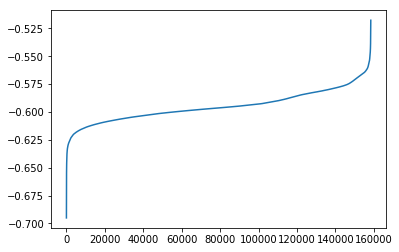

In [29]:
plt.plot(np.sort(preds.ravel()))

In [30]:
def preds_to_tensor(preds, kernel_size, n, w, h):
    return np.reshape(preds, (n, w - (kernel_size - 1), h - (kernel_size - 1)))

In [31]:
t = preds_to_tensor(preds, 3, 1, 400, 400)

In [41]:
t[0].shape

(398, 398)

# Old Shit

In [ ]:
# Build train tensor

#X_var = Variable(torch.from_numpy(np.stack(imgs))) # tensor (N, W, H, C)
X_var = Variable(torch.from_numpy(np.stack(imgs[:10])), requires_grad=False)

In [ ]:
lr = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
costf = torch.nn.MSELoss()

In [ ]:
# Build groundtruth tensor

#Y_var = Variable(torch.from_numpy(np.stack(gt_imgs)))
Y_var = Variable(torch.from_numpy(np.stack(gt_imgs[:10])), requires_grad=False)

In [ ]:
train(X_var, Y_var, model, costf, optimizer, 50)

In [ ]:
# Choose image to analyze
img = imgs[0]

In [ ]:
# Predict and give correct shape
test_x = Variable(torch.from_numpy(img).unsqueeze(0))
preds = model(test_x).squeeze(0).data.numpy()

In [ ]:
plt.plot(np.sort(np.ravel(preds)))

In [ ]:
preds.max()

In [ ]:
# Draw
cimg = utils.concatenate_images(img, preds)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [ ]:
new_img = utils.make_img_overlay(img, preds)
plt.figure(figsize=(10,10))
plt.imshow(new_img)